## Testing SVD cutoff shaking

In [1]:
import numpy as np
import torch

from mps.models import MPS, ComplexTensor
from mps.utils import build_ghz_plus, train_from_dict
from mps.qutip_utils import get_ghz_state as get_qutip_ghz

import matplotlib.pyplot as plt
import datetime
import json

Loaded libmkl_rt.so for dgesvd


Pick system size, dimensionality of local hilbert space, and initial bond dim

In [2]:
L=6
local_dim=2
bond_dim=2

In [3]:
# dev = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
dev = torch.device("cpu")

Initialize the MPS model

In [4]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [5]:
psi.to(device=dev)

The ground truth state (a ghz state with no phase)

In [6]:
ghz_plus = build_ghz_plus(L)
ghz_plus.to(device=dev)
ghz_qutip = get_qutip_ghz(L,phase=0)

In [7]:
fname_settings = "datasets/mps_sampled/ghz_plus_L=%d_angles.npy"%L
fname_samples = "datasets/mps_sampled/ghz_plus_L=%d_outcomes.npy"%L
mps_path = "datasets/mps_sampled/ghz_plus_L=%d_state"%L
Nsamp=20000


In [8]:
fname_training_settings = "experiments/ghz_val/data/training_settings.json"
with open(fname_training_settings) as f:
    training_settings = json.load(f)

In [9]:
training_settings["mps_path"] = mps_path
training_settings["max_sv"] = 25
training_settings["shake_cutoff"]= True
training_settings["epochs"]=10
training_settings['lr_scale']=1e-2
training_settings["batch_size"] = 1024
training_settings['cutoff']=1e-3


Max number of singular values to keep, and cutoff below which to truncate singular values

In [10]:
model, logdict, meta = train_from_dict(fname_samples, fname_settings, training_settings,N=Nsamp,
                                   record_eigs=True,record_s2=True,verbose=True,
                                   compute_overlaps=False,samples_per_epoch=20)

Successfully loaded 20000 settings, samples for system of size L=6
Loaded the following settings:
lr_scale = 1.000000e-02
lr_timescale = 9.058899e+01
s2_scale = 3.107953e-06
s2_timescale = 7.610777e+01
epochs = 1.000000e+01
cutoff = 1.000000e-03
max_sv = 2.500000e+01
batch_size = 1.024000e+03
Shake cutoff: True
loading ground truth MPS from  datasets/mps_sampled/ghz_plus_L=6_state
Training on system size 6 with 20000 samples
Finished epoch 0 in 1.288 sec
Model shape:  [(1, 2), (2, 3), (3, 4), (4, 3), (3, 2), (2, 1)]
Finished epoch 1 in 1.280 sec
Model shape:  [(1, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 1)]
Finished epoch 2 in 1.276 sec
Model shape:  [(1, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 1)]
Finished epoch 3 in 1.273 sec
Model shape:  [(1, 2), (2, 4), (4, 6), (6, 4), (4, 2), (2, 1)]
Finished epoch 4 in 1.354 sec
Model shape:  [(1, 2), (2, 4), (4, 7), (7, 4), (4, 2), (2, 1)]
Finished epoch 5 in 1.380 sec
Model shape:  [(1, 2), (2, 4), (4, 8), (8, 4), (4, 2), (2, 1)]
Finished epoc

In [11]:
fidelity_mps = logdict['fidelity_mps']

loss = logdict['loss']
max_bond_dim = logdict['max_bond_dim']
eigs = logdict['eigenvalues']
s2 = logdict['s2']


Text(0.5,1,'batch NLL loss')

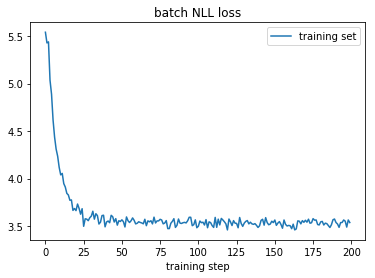

In [12]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(loss, label='training set')
plt.legend()
plt.xlabel("training step")
plt.title("batch NLL loss")


Text(0.5,1,'Ground truth fidelity')

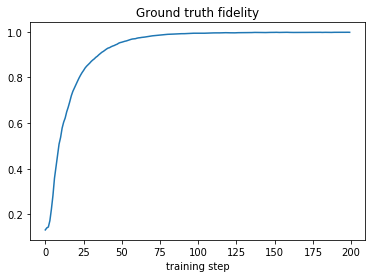

In [13]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(fidelity_mps)
plt.xlabel("training step")
plt.title("Ground truth fidelity")


In [ ]:
fid

Text(0.5,1,'Max bond dimension')

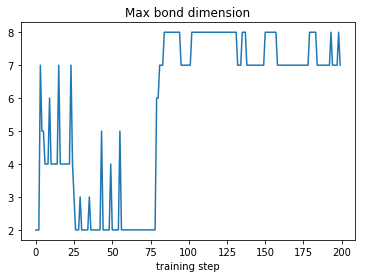

In [14]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(max_bond_dim)
plt.xlabel("training step")
plt.title("Max bond dimension")
